In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Load data

In [2]:
from pathlib import Path
import os

data_dir = Path('./data/')
data_path = Path('./data/fashion_mnist.npz')

if data_path.is_file():
    print('Data found. Loading...')
    data = np.load(data_path)
    X_train, Y_train, X_test, Y_test = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
else:
    print('Data not found. Downloading...')
    if not data_dir.is_dir():
        os.mkdir(data_dir)
    from keras.datasets import fashion_mnist
    (X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()
    X_train, X_test = X_train/255., X_test/255.
    np.savez_compressed(data_path, X_train, Y_train, X_test, Y_test)

Data found. Loading...


In [3]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [4]:
CLASS_LABELS = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot'
]

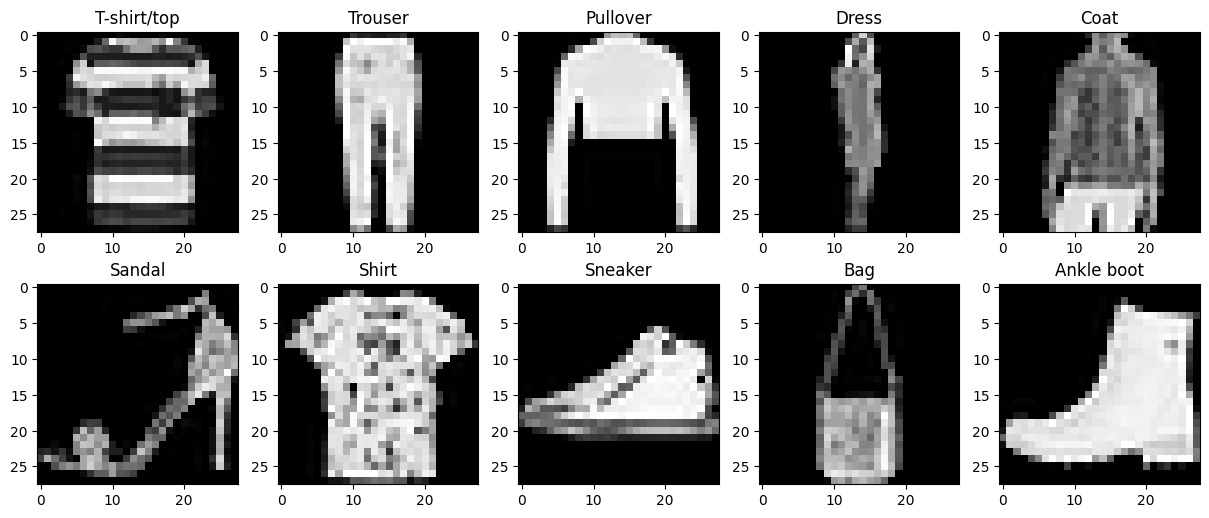

In [5]:
fig, ax = plt.subplots(2, 5, figsize=(15, 6))
for i in range(10):
    row_no = i//5
    col_no = i%5
    X_sub = X_train[Y_train==i]
    index = np.random.choice(a=range(len(X_sub)), size=1)
    ax[row_no][col_no].imshow(X_sub[index].reshape((28, 28)), cmap='gray')
    ax[row_no][col_no].set_title(CLASS_LABELS[i])

## Activations

In [6]:
class Identity():
    """
    Implements the identity function, f(x) = x
    """
    def __init__(self) -> None:
        pass

    def forward(self, x: np.array) -> np.array:
        """
        Returns identity(x) for input x

        Arg: x (np.array): The input
        Returns: identity(x) (np.array): The output, identity(x) (= x) 
        """
        return x
    
    def backward(self, output: np.array, y_true=None) -> np.array:
        """
        Returns gradient of identity output wrt inputs, given the output

        Args:
            output (np.array): The output produced by the identity activation, corresponding to the input for which gradient
                is being computed.
            y_true (optional): Compatibility feature, required for softmax activation. Not used in computation.
                Defaults to None.
        
        Returns:
            grad (np.array): The gradient of the identity activation wrt the required inputs (for which the output is passed
                as proxy)
        """
        return np.ones_like(output)

In [7]:
class Sigmoid():
    """
    Implements the sigmoid logistic function, f(x) = 1/(1 + exp(-x))
    """
    def __init__(self) -> None:
        pass

    def forward(self, x: np.array) -> np.array:
        """
        Returns sigmoid(x) for input x

        Arg: x (np.array): The input
        Returns: sigmoid(x) (np.array): The output, sigmoid(x)
        """
        return 1 / (1 + np.exp(-x))
    
    def backward(self, output: np.array, y_true=None) -> np.array:
        """
        Returns gradient of sigmoid outputs wrt inputs, given the output

        Args:
            output (np.array): The output produced by the sigmoid activation, corresponding to the input for which gradient
                is being computed.
            y_true (optional): Compatibility feature, required for softmax activation. Not used in computation.
                Defaults to None.
        
        Returns:
            grad (np.array): The gradient of the sigmoid activation wrt the required inputs (for which the output is passed
                as proxy)
        """
        return output * (1 - output)

In [8]:
class ReLU():
    """
    Implements the rectified linear unit (ReLU) function, f(x) = max(0, x) 
    """
    def __init__(self) -> None:
        pass
        
    def forward(self, x: np.array) -> np.array:
        """
        Returns relu(x) for input x

        Arg: x (np.array): The input
        Returns: relu(x) (np.array): The output, relu(x)
        """
        return np.maximum(0., x)
    
    def backward(self, output: np.array, y_true=None) -> np.array:
        """
        Returns gradient of relu outputs wrt inputs, given the output

        Args:
            output (np.array): The output produced by the relu activation, corresponding to the input for which gradient
                is being computed.
            y_true (optional): Compatibility feature, required for softmax activation. Not used in computation.
                Defaults to None.
        
        Returns:
            grad (np.array): The gradient of the relu activation wrt the required inputs (for which the output is passed
                as proxy)
        """
        return np.sign(output, dtype=np.float64)

In [9]:
class Tanh():
    """
    Implements the hyperbolic tan (tanh) function, f(x) = (exp(x) - exp(-x))/(exp(x) + exp(-x))
    """
    def __init__(self) -> None:
        pass

    def forward(self, x: np.array) -> np.array:
        """
        Returns tanh(x) for input x

        Arg: x (np.array): The input
        Returns: tanh(x) (np.array): The output, tanh(x)
        """
        # tanh(x) = (exp(2x) - 1)/(exp(2x) + 1) = 2 / (1 + exp(-2x)) - 1
        return 2 / (1 + np.exp(-2*x)) - 1
    
    def backward(self, output: np.array, y_true=None) -> np.array:
        """
        Returns gradient of tanh outputs wrt inputs, given the output

        Args:
            output (np.array): The output produced by the tanh activation, corresponding to the input for which gradient
                is being computed.
            y_true (optional): Compatibility feature, required for softmax activation. Not used in computation.
                Defaults to None.
        
        Returns:
            grad (np.array): The gradient of the tanh activation wrt the required inputs (for which the output is passed
                as proxy)
        """
        # d(tanh(x))/dx = 4exp(2x)/(1 + exp(2x))**2
        # exp(2x)/(1 + exp(2x)) = (tanh(x) + 1)/2, 1/(1 + exp(2x)) = (1 - tanh(x))/2
        # d(tanh(x))/dx = 1 - tanh(x)**2
        return 1 - output**2

In [115]:
class Softmax():
    """
    Implements the softmax function, f(x) = exp(x) / sum(exp(x))
    """
    def __init__(self) -> None:
        pass

    def forward(self, x: np.array) -> np.array:
        """
        Returns softmax(x) for input x

        Arg: x (np.array): The input
        Returns: softmax(x) (np.array): The output, softmax(x)
        """
        max_x = np.max(x, axis=-1).reshape(-1, 1)
        exp_x = np.exp(x - max_x)
        total = np.sum(exp_x, axis=-1).reshape(-1, 1)
        return (exp_x / total).reshape(x.shape)
    
    def backward(self, output: np.array, y_true) -> np.array: 
        """
        Returns gradient of softmax outputs wrt inputs, given the output and true class

        Args:
            output (np.array): The output produced by the softmax activation, corresponding to the input for which gradient
                is being computed.
            y_true : The true classes corresponding to the producing outputs. Could be a scalar or an array.
        
        Returns:
            grad (np.array): The gradient of the softmax activation wrt the required inputs (for which the output is passed
                as proxy)
        """
        e_l = np.zeros_like(output)
        if len(output.shape) == 1:
            e_l[y_true] = 1.
            return output[y_true] * (e_l - output)
        else:
            for i,y in enumerate(y_true):
                e_l[i][y] = 1.
            relevant_outputs = np.array([output[i][y] for i,y in enumerate(y_true)]).reshape(-1, 1)
            return relevant_outputs * (e_l - output)
        

## Loss functions

In [124]:
class CrossEntropyLoss():
    """
    Implements the cross entropy loss, L(y_hat, y) = -log(y_hat[y]) [where y is the true class label, from 0 to num_classes-1]

    Arg: eps (float, optional): quantity added to predicted probability for stability during log and division.
        Deafults to 1e-8.
    """
    def __init__(self, eps: float=1e-8) -> None:
        self.eps = eps

    def forward(self, y_pred: np.array, y_true) -> np.float64:
        """
        Returns the loss for predicted probabilities y_pred, with true class label y_true

        Args:
            y_pred (np.array): The predicted probabilities of each of the classes. 
                Array of shape (num_classes,) or (num_samples, num_classes).
            y_true: The true class label(s) of the data point(s). Could be a scalar or an array of shape (num_samples,).

        Returns:
            The (average) cross entropy loss (across all samples), a np.float64 object.
        """
        if len(y_pred.shape) == 1:
            return -np.log(np.minimum(y_pred[y_true] + self.eps, 1.))
        else:
            return np.mean(np.array([
                -np.log(np.minimum(y_pred[i][y] + self.eps, 1.)) for i,y in enumerate(y_true)
            ]))
    
    def backward(self, y_pred: np.array, y_true) -> np.array:
        """
        Returns the derivative of the loss wrt the predicted probability of the true class y_true

        Args:
            y_pred (np.array): The predicted probabilities of each of the classes. 
                Array of shape (num_classes,) or (num_samples, num_classes).
            y_true: The true class label(s) of the data point(s). Could be a scalar or an array of shape (num_samples,).

        Returns:
            grad (np.array): The gradient of the loss wrt the inputs (probabilties) given to the loss function.
                Array of shape matching y_pred.
        """
        grad = np.zeros_like(y_pred)
        if len(y_pred.shape) == 1:
            grad[y_true] = -1 / (np.minimum(y_pred[y_true] + self.eps, 1.))
        else:
            for i,y in enumerate(y_true):
                grad[i][y] = -1 / (np.minimum(y_pred[i][y] + self.eps, 1.))
        return grad


## Feedforward neural network

In [161]:
class Layer():
    """
    Models a single layer of a feedforward neural network. 

    Args:
        input_size (int): number of inputs to the layer
        output_size (int): number of outputs produced by the layer
        activation (str, optional): activation function used by the layer. 
            Allowed activations: 'identity', 'sigmoid', 'tanh', 'relu', 'softmax'
            Defaults to 'sigmoid'.
        weight_init (str, optional): type of initialization to be performed for the weights and biases
            Allowed initializations: 'random', 'xavier'
            Defaults to 'random'.
    """
    def __init__(
        self,
        input_size: int,
        output_size: int,
        activation: str = 'sigmoid',
        weight_init: str = 'random'
    ) -> None:
        # Handle to allow weight init
        self.w = np.random.normal(size=(output_size, input_size))   # shape: (output_size, input_size)
        self.b = np.random.normal(size=(output_size,))  # shape: (output_size,)
        self.grad_w = np.zeros_like(self.w)
        self.grad_b = np.zeros_like(self.b)
        if activation == 'identity':
            self.activation = Identity()
        elif activation == 'sigmoid':
            self.activation = Sigmoid()
        elif activation == 'tanh':
            self.activation = Tanh()
        elif activation == 'relu':
            self.activation = ReLU()
        elif activation == 'softmax':
            self.activation = Softmax()
    
    def forward(self, x: np.array) -> np.array:
        """
        Computes the output of the layer for given input.

        Arg: x (np.array): the input vector for the layer, of size (input_size,) or (num_samples, input_size).
        Returns: h (np.array): the output produced by the layer, of size (output_size,) or (num_samples, output_size).
        """
        self.input = x
        self.pre_activation = np.matmul(x, self.w.T) + self.b
        self.output = self.activation.forward(self.pre_activation)
        return self.output
    
    def backward(self, accumulated_grads: np.array, y_true=None, w_next: np.array = None) -> np.array:
        """
        Computes the relevant necessary gradients of the layer, given the gradient accumulated until the succeeding layer.

        Args:
            accumulated_grads (np.array): gradient accumulated from the loss until the following layer, i.e. grad(L) wrt a_(i+1)
                Array of shape (num_features,) or (num_samples, num_features).
            y_true (optional): compatiblity feature, required only for the output layer for softmax activation.
                Defaults to None.
            w_next (np.array, optional): weight associated with the succeeding layer. Not applicable for the output layer.
                Defaults to None.
        
        Returns: grad_to_return (np.array), gradient accumulated until the current layer, i.e., grad(L) wrt a_i
        """
        # accumulated_grads ~ grad(L) wrt a_i+1
        # print(f'Accumulated grads: {accumulated_grads.shape}, W: {self.w.shape}, b: {self.b.shape}')
        activation_grad = self.activation.backward(self.output, y_true)
        if w_next is not None:
            grad_to_return = np.matmul(accumulated_grads, w_next) * activation_grad
        else:
            grad_to_return = accumulated_grads * activation_grad # shape = self.output.shape
        # grad_to_return ~ grad(L) wrt a_i
        # print(f'Grad of activation:{activation_grad.shape}, Grad to return: {grad_to_return.shape}, input: {self.input.shape}')
        self.grad_w += np.matmul(grad_to_return.T.reshape(self.w.shape[0], -1), self.input.reshape(-1, self.w.shape[1])) / self.input.reshape(-1, self.w.shape[1]).shape[0]
        if len(self.input.shape) == 1:
            self.grad_b += grad_to_return
        else:
            self.grad_b += np.mean(grad_to_return, axis=0)
        return grad_to_return

In [237]:
class FeedForwardNeuralNetwork():
    """
    Models a vanilla feedforward neural network, with softmax activation for the outputs.

    Args:
        num_layers (int): number of hidden layers in the network
        hidden_size (int): number of neurons per hidden layer
        input_size (int): size/dimension of inputs given to the network. 
            Defaults to 784, flattened size of mnist/fashion-mnist data.
        output_size (int): number of outputs produced by the network.
            Defaults to 10, number of classes of mnist/fashion-mnist data.
        activation (str, optional): activation function for the hidden layers.
            Allowed activations: 'identity', 'sigmoid', 'tanh', 'relu'
            Defaults to 'sigmoid'.
        weight_init (str, optional): type of initialization to be performed for the weights and biases
            Allowed initializations: 'random', 'xavier'
            Defaults to 'random'.
    """
    def __init__(
        self,
        num_layers: int,
        hidden_size: int,
        input_size: int = 784,
        output_size: int = 10,
        activation: str = 'sigmoid',
        weight_init: str = 'random'
    ) -> None:
        self.input_layer = Layer(input_size, hidden_size, activation, weight_init)
        self.hidden_layers = []
        for i in range(num_layers-1):
            self.hidden_layers.append(Layer(hidden_size, hidden_size, activation, weight_init))
        self.output_layer = Layer(hidden_size, output_size, 'softmax', weight_init)
    
    def forward(self, x: np.array) -> np.array:
        """
        Computes the output of the network for given input.

        Arg: x (numpy.array): the input to the network, of size (input_size,)
        Returns: y_hat (numpy.array): the output produced by the network, of size (output_size,)
        """
        result = self.input_layer.forward(x)
        for hidden_layer in self.hidden_layers:
            result = hidden_layer.forward(result)
        return self.output_layer.forward(result)
    
    def backward(self, accumulated_grads: np.array, y_true) -> None:
        """
        Computes the gradient of the loss wrt all the parameters (weights, biases) of the network, given the gradient of the loss
        wrt the output of the network.

        Args:
            accumulated_grads (np.array): gradient of the loss wrt the outputs of the network
                Array of size (num_classes,) or (num_samples, num_classes).
            y_true: the true class label(s) for the data input(s) to the network
        """
        accumulated_grads = self.output_layer.backward(accumulated_grads, y_true)
        w_next = self.output_layer.w
        for hidden_layer in reversed(self.hidden_layers):
            accumulated_grads = hidden_layer.backward(accumulated_grads, w_next=w_next)
            w_next = hidden_layer.w
        self.input_layer.backward(accumulated_grads, w_next=w_next)
    
    def zero_grad(self) -> None:
        """
        Sets the gradients of all the parameters of the network to zero.
        """
        self.output_layer.grad_w, self.output_layer.grad_b = 0., 0.
        for hidden_layer in self.hidden_layers:
            hidden_layer.grad_w, hidden_layer.grad_b = 0., 0.
        self.input_layer.grad_w, self.input_layer.grad_b = 0., 0.
    
    def update_weights(self, lr: float = 1e-3) -> None:
        """
        Updates the parameters of the network along the direction of the negative gradient.

        Arg: lr (float, optional): learning rate for the update. Defaults to 1e-3.
        """
        self.output_layer.w -= lr * self.output_layer.grad_w
        self.output_layer.b -= lr * self.output_layer.grad_b
        for hidden_layer in self.hidden_layers:
            hidden_layer.w -= lr * hidden_layer.grad_w
            hidden_layer.b -= lr * hidden_layer.grad_b
        self.input_layer.w -= lr * self.input_layer.grad_w
        self.input_layer.b -= lr * self.input_layer.grad_b
        

## Optimizers

In [221]:
# Create classes for each optimizer, get the model in constructor and store as member, then make a step method to do the required calculations and update

class StochasticGradientDescent():
    """
    Class to implement stochastic (mini-batch vanilla) gradient descent optimization algorithm on a model.

    Args:
        model (FeedForwardNeuralNetwork): The model whose parameters are to be learned.
        lr (float, optional): The learning rate for the updates. Defaults to 1e-3.
    """
    def __init__(
        self,
        model: FeedForwardNeuralNetwork,
        lr: float = 1e-3
    ) -> None:
        self.model = model
        self.lr = lr

    def step(self) -> None:
        """
        Performs one step/update to the parameters of the model, using grads computed by the model's backward function.
        """
        self.model.output_layer.w -= self.lr * self.model.output_layer.grad_w
        self.model.output_layer.b -= self.lr * self.model.output_layer.grad_b
        for hidden_layer in self.model.hidden_layers:
            hidden_layer.w -= self.lr * hidden_layer.grad_w
            hidden_layer.b -= self.lr * hidden_layer.grad_b
        self.model.input_layer.w -= self.lr * self.model.input_layer.grad_w
        self.model.input_layer.b -= self.lr * self.model.input_layer.grad_b


In [249]:
class MomentumGradientDescent():
    """
    Class to implement momentum-based gradient descent optimization algorithm on a model.

    Args:
        model (FeedForwardNeuralNetwork): The model whose parameters are to be learned.
        lr (float, optional): The learning rate for the updates. Defaults to 1e-3.
        beta (float, optional): The momentum to be used, quantifying the confidence in the history of updates.
            Should range from 0 to 1. Defaults to 0.9.
    """
    def __init__(
        self,
        model: FeedForwardNeuralNetwork,
        lr: float = 1e-3,
        beta: float = 0.9,
    ) -> None:
        self.model = model
        self.beta = beta
        self.lr = lr
        self.input_u_w = np.zeros_like(model.input_layer.w)
        self.input_u_b = np.zeros_like(model.input_layer.b)
        self.hidden_u_ws = []
        self.hidden_u_bs = []
        for hidden_layer in model.hidden_layers:
            self.hidden_u_ws.append(np.zeros_like(hidden_layer.w))
            self.hidden_u_bs.append(np.zeros_like(hidden_layer.b))
        self.output_u_w = np.zeros_like(model.output_layer.w)
        self.output_u_b = np.zeros_like(model.output_layer.b)

    def step(self) -> None:
        """
        Performs one step/update to the parameters of the model, using grads computed by the model's backward function.
        """
        self.output_u_w = self.beta * self.output_u_w + self.lr * self.model.output_layer.grad_w
        self.model.output_layer.w -= self.output_u_w
        self.output_u_b = self.beta * self.output_u_b + self.lr * self.model.output_layer.grad_b
        self.model.output_layer.b -= self.output_u_b
        for hidden_layer, hidden_u_w, hidden_u_b in zip(self.model.hidden_layers, self.hidden_u_ws, self.hidden_u_bs):
            hidden_u_w = self.beta * hidden_u_w + self.lr * hidden_layer.grad_w
            hidden_layer.w -= hidden_u_w
            hidden_u_b = self.beta * hidden_u_b + self.lr * hidden_layer.grad_b
            hidden_layer.b -= hidden_u_b
        self.input_u_w = self.beta * self.input_u_w + self.lr * self.model.input_layer.grad_w
        self.model.input_layer.w -= self.input_u_w
        self.input_u_b = self.beta * self.input_u_b + self.lr * self.model.input_layer.grad_b
        self.model.input_layer.b -= self.input_u_b

In [ ]:
class NesterovGradientDescent():
    def __init__(
        self,
        model: FeedForwardNeuralNetwork,
        lr: float = 1e-3,
        beta: float = 0.9
    ) -> None:
        self.model = model
        self.lr = lr
        self.beta = beta
        self.input_u_w = np.zeros_like(model.input_layer.w)
        self.input_u_b = np.zeros_like(model.input_layer.b)
        self.hidden_u_ws = []
        self.hidden_u_bs = []
        for hidden_layer in model.hidden_layers:
            self.hidden_u_ws.append(np.zeros_like(hidden_layer.w))
            self.hidden_u_bs.append(np.zeros_like(hidden_layer.b))
        self.output_u_w = np.zeros_like(model.output_layer.w)
        self.output_u_b = np.zeros_like(model.output_layer.b)

# Important extra requirement: gradient computation with different weights -> how to handle? Maybe store current weights (and grads), then run backprop with projected weights? Or don't call backward for each layer and instead handle it here?

## Checking out

In [250]:
random_indices = np.random.choice(range(len(X_train)), 100, replace=False)
random_indices

array([35117, 18140,  7729, 58584, 48217, 29554, 17589,   450, 15191,
       30787, 17890, 31296, 21226, 29826,  5912, 12648, 43806, 13093,
       54437, 56357, 54283,  8853, 48866, 16612, 40344, 14921, 15713,
       25767,  6994, 45079, 10557, 54454, 48061, 46198, 16997,  1145,
       53840, 46194, 57649, 34603, 43465, 30625,  6560, 11831, 56150,
       30617, 47828, 31301, 36029, 50207, 40987, 59004, 35242, 30776,
       33222, 39712, 49157, 34885, 17680, 15332, 25254, 19404, 20177,
       22230, 21657,  4860, 55663, 41645, 43238,   353,  7797, 42807,
        9488, 54605,  9451, 56439, 15185, 20738,  8940, 10493, 46287,
       48532, 56710, 37439, 23363, 22445, 24272, 48883, 31959, 47027,
       54980, 56145, 33783, 32472, 25638, 35645, 52991,   650, 45816,
        7497])

In [251]:
X_train[random_indices].shape

(100, 28, 28)

In [252]:
X_sub = X_train[random_indices].reshape(len(random_indices), -1)
X_sub.shape

(100, 784)

In [253]:
Y_sub = Y_train[random_indices]
Y_sub.shape

(100,)

In [288]:
np.random.seed(3863)

model = FeedForwardNeuralNetwork(num_layers=3, hidden_size=100, activation='sigmoid')

In [289]:
loss_fn = CrossEntropyLoss()

In [290]:
train_history = {
    'epoch': [],
    'loss': []
}

optimizer = StochasticGradientDescent(model, 0.1)

for i in range(100):
    model.zero_grad()
    y_pred = model.forward(X_sub)
    loss = loss_fn.forward(y_pred, Y_sub)
    grad_loss = loss_fn.backward(y_pred, Y_sub)
    model.backward(grad_loss, Y_sub)
    optimizer.step()
    print(i, loss, sep='\t\t')
    train_history['epoch'].append(i)
    train_history['loss'].append(loss)

0		12.106140827509085
1		11.758865715917683
2		11.399749002724391
3		11.029996728299311
4		10.651800237610614
5		10.26927545963116
6		9.889218170180778
7		9.518534150939065
8		9.162519564092532
9		8.826070366023776
10		8.513848229309257
11		8.228850559211889
12		7.971612554541672
13		7.741152782320054
14		7.53619174205785
15		7.3557913814948
16		7.199205705691216
17		7.065312950603481
18		6.95223955794276
19		6.857407476738819
20		6.7779307359174785
21		6.711054597481199
22		6.654374218470757
23		6.605827526466551
24		6.563637100610614
25		6.5263257566176005
26		6.492760039478407
27		6.462145733168398
28		6.433972225307939
29		6.407932931407131
30		6.383843340771467
31		6.361573360362201
32		6.341005259511346
33		6.322017186890312
34		6.304482398224673
35		6.28827315457444
36		6.273263248375052
37		6.259328127196812
38		6.246343697758269
39		6.234184822564349
40		6.222724017746991
41		6.21183089032771
42		6.20137325297785
43		6.19122085061418
44		6.181251728226339
45		6.171359864493954

Text(0, 0.5, 'Loss')

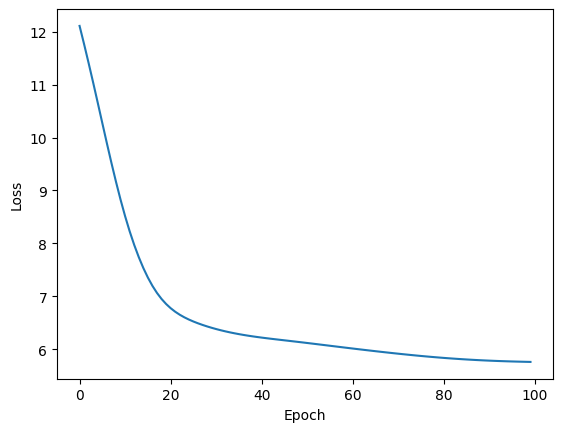

In [291]:
plt.plot(train_history['epoch'], train_history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [292]:
train_preds = np.argmax(model.forward(X_sub), axis=1)
train_preds.shape

(100,)

In [293]:
np.sum(train_preds == Y_sub)/len(Y_sub)

0.45